### Bidirectional LSTM Model

A bidirectional LSTM (BiLSTM) enhances the traditional LSTM by processing input sequences in both forward (past to future) and backward (future to past) directions, enabling the model to access context from both preceding and succeeding time steps. This dual approach provides richer sequence understanding and captures dependencies that unidirectional LSTMs might miss, making BiLSTMs especially valuable in tasks like Remaining Useful Life (RUL) prediction and natural language processing. The outputs from both directions are combined—usually by concatenation or summation—to form a comprehensive representation at each time step. While bidirectional LSTMs improve context awareness and accuracy, they require the entire sequence upfront, leading to increased training time and computational complexity, thus being better suited for offline or batch processing rather than real-time streaming.

In [11]:
# --- Import additional layers and tools for experimentation ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau    

In [12]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("../../../data/preprocessed/rolling_window_sequences.npy")      # Feature array

# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("../../../data/preprocessed/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [13]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [14]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [15]:
# Bidirectional LSTM layer to capture forward and backward temporal dependencies
def build_bidirectional_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model = build_bidirectional_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128)               67072     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1
)

In [17]:
# Model Training
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/30

1906/1907 [============================>.] - ETA: 0s - loss: 14028.2441
Epoch 1: saving model to best_model.keras
1907/1907 [==============================] - 30s 14ms/step - loss: 14024.3760 - val_loss: 8560.6758 - lr: 0.0010
Epoch 2/30
1905/1907 [============================>.] - ETA: 0s - loss: 6150.4731
Epoch 2: saving model to best_model.keras
1907/1907 [==============================] - 26s 14ms/step - loss: 6148.0435 - val_loss: 4271.6118 - lr: 0.0010
Epoch 3/30
1906/1907 [============================>.] - ETA: 0s - loss: 4078.7073
Epoch 3: saving model to best_model.keras
1907/1907 [==============================] - 29s 15ms/step - loss: 4077.9365 - val_loss: 3659.1069 - lr: 0.0010
Epoch 4/30
1906/1907 [============================>.] - ETA: 0s - loss: 3688.9058
Epoch 4: saving model to best_model.keras
1907/1907 [==============================] - 26s 14ms/step - loss: 3688.3071 - val_loss: 3370.8142 - lr: 0.0010
Epoch 5/30
1907/1907 [==============================]

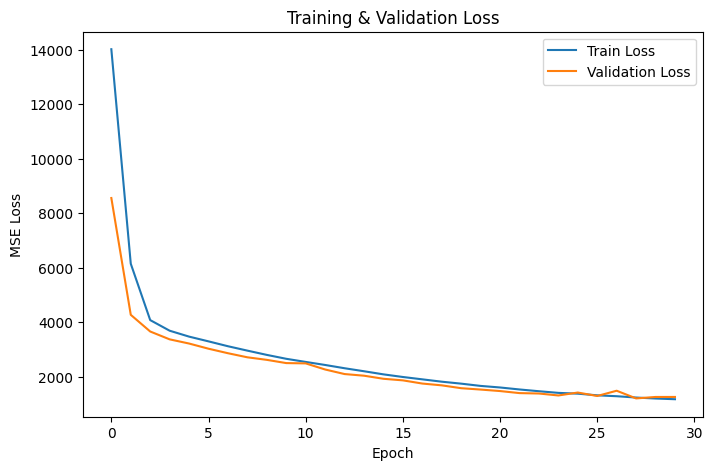

In [20]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step


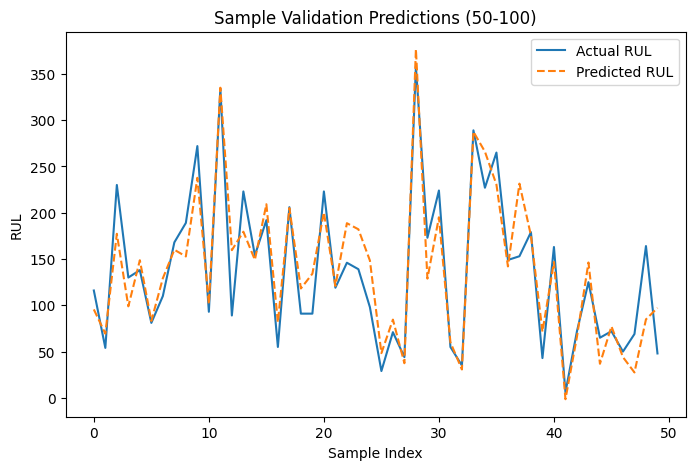

In [25]:
# Verify Model Predictions
val_pred = model.predict(X_val[50:100]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[50:100], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (50-100)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()